In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.path import Path


from bgspy.tree_utils import load_recrates, load_neutregions
from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro, BScores
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores, exact_index
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.theory import bgs_segment
from bgspy.classic import BSC16_segment_lazy

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

TODO

 - nans in low rec causing issue?
 - Neh vs Ne

In [107]:
force = True

### bgspy B maps

In [ ]:
w_grid = np.array([1e-10, 3.16e-10, 1e-9, 3.16e-9, 1e-8, 3.16e-8])
t_grid = np.array([0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1])

pkl_b_file = '../data/bmaps/bgspy/B_chr10_all.pkl'

if force or not os.path.exists(pkl_b_file):
    g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
    g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
    g.load_recmap("../data/annotation/HapMapII_GRCh37_liftedOverTo_Hg38/genetic_map_Hg38_chr10.txt")
    
    m = BGSModel(g, w_grid=w_grid, t_grid=t_grid, split_length=1_000)
    m.calc_Bp(N=1000, step=1_000, ncores=70, nchunks=200)
    m.calc_B(step=1_000, ncores=70, nchunks=70)
    m.save(pkl_b_file)
else:
    m = BGSModel.load(pkl_b_file)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.
calculating SC16 components...	

In [92]:
m.calc_Bp(N=1000, step=10_000, ncores=70, nchunks=200)

Genome divided into 200 chunks to be processed on 70 CPUs...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [07:01<00:00,  2.11s/it]


In [ ]:
bp = m.BpScores
b = m.BScores

### `calc_bkgd` maps

In [9]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_1000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)


In [110]:
sim_B = np.load('../data/slim_sims/chrombgs_chr10/sim_B.npz', allow_pickle=True)

In [111]:
mus = sim_B['mu']
shs = sim_B['sh']

In [112]:
mus, shs

(array([1.e-10, 2.e-10, 1.e-09, 2.e-09, 1.e-08, 2.e-08]),
 array([0.0001 , 0.00022, 0.00046, 0.001  , 0.0022 , 0.0046 , 0.01   ,
        0.022  , 0.046  , 0.1    ]))

In [113]:
simb_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

In [114]:
sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': simb_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': simb_pos}, mus, shs, step=None)

In [115]:
bp['chr10', mu, sh][0].shape, bp['chr10', mu, sh][1].shape

((13381,), (13381,))

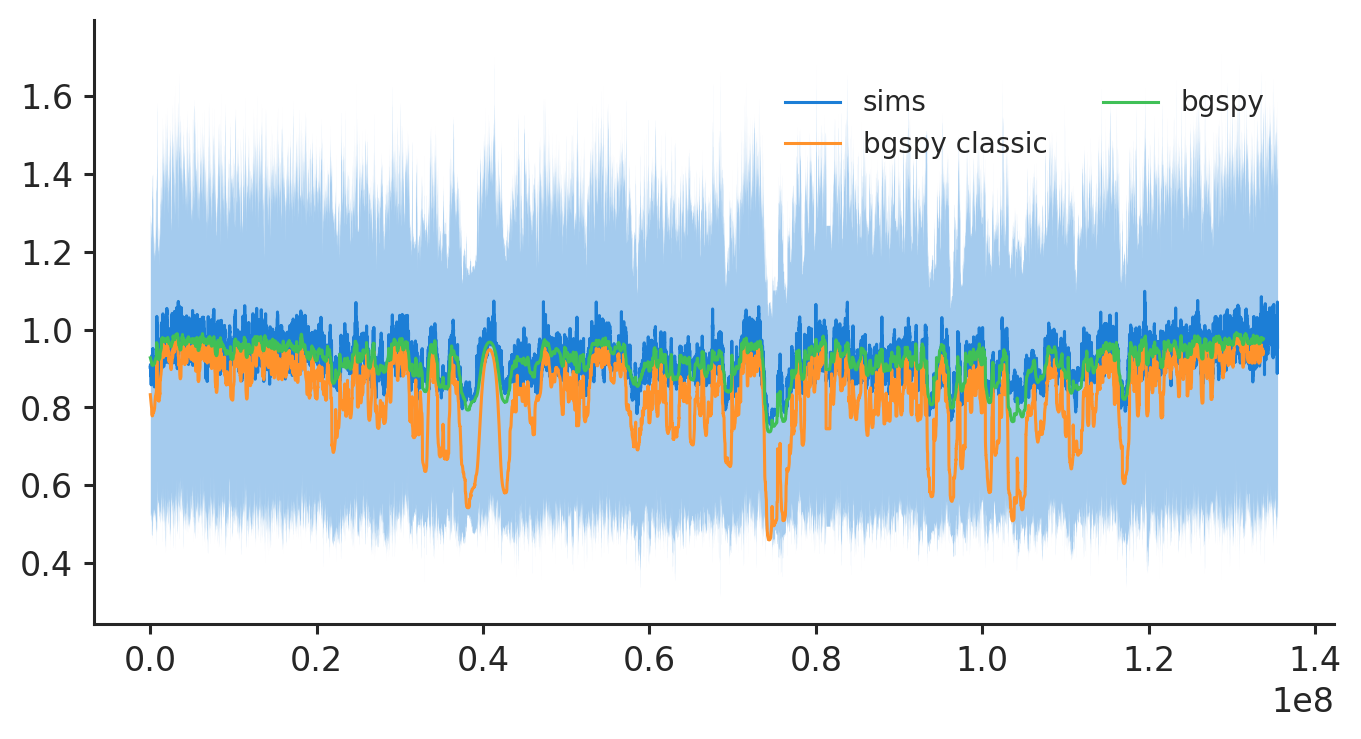

In [134]:
sh = 0.001
mu = 1.e-9


lines = plt.plot(*sims_means['chr10', mu, sh], label='sims')
sim_pos, sd = sims_sds['chr10', mu, sh]
_, mean = sims_means['chr10', mu, sh]
plt.fill_between(sim_pos, mean - sd, mean + sd, alpha=0.4, 
                 linewidth=0, color=lines[0].get_color())

plt.plot(*b['chr10', mu, sh], label='bgspy classic', zorder=2)
plt.plot(*bp['chr10', mu, sh], label='bgspy')

plt.legend(ncol=2)


In [81]:
T, Ne, Q2, V, Vm, U = m.genome.segments._segment_parts_sc16

array([    10721,     11721,     12721, ..., 133778652, 133778795,
       133779795], dtype=uint32)

[]

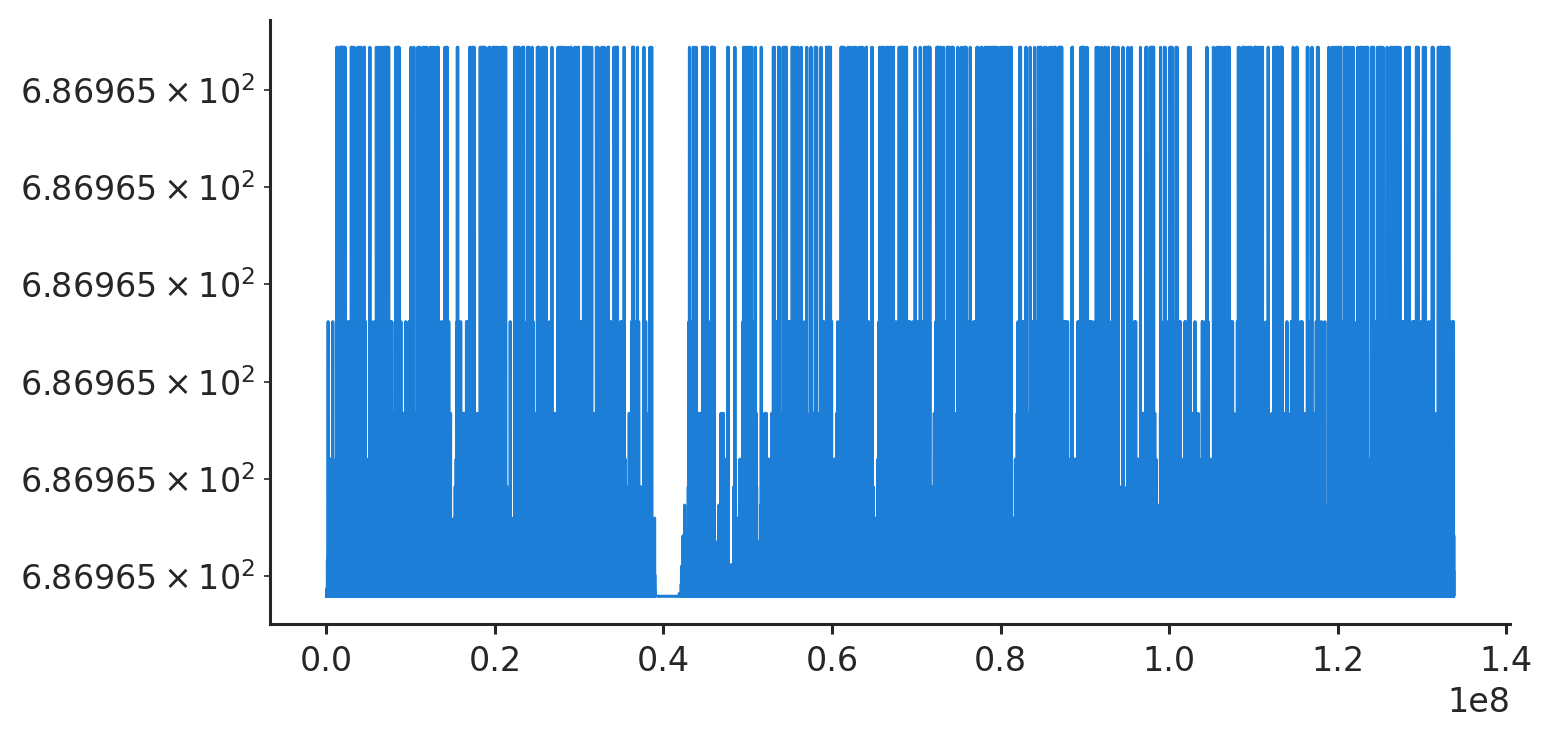

In [90]:
plt.plot(m.genome.segments.ranges[:, 0], V[4, 3,:]/Vm[4, 3,:])
plt.semilogy()

In [106]:
np.logspace(-4, -1, 7)

array([0.0001    , 0.00031623, 0.001     , 0.00316228, 0.01      ,
       0.03162278, 0.1       ])

building interpolators...		done.
building interpolators...		done.


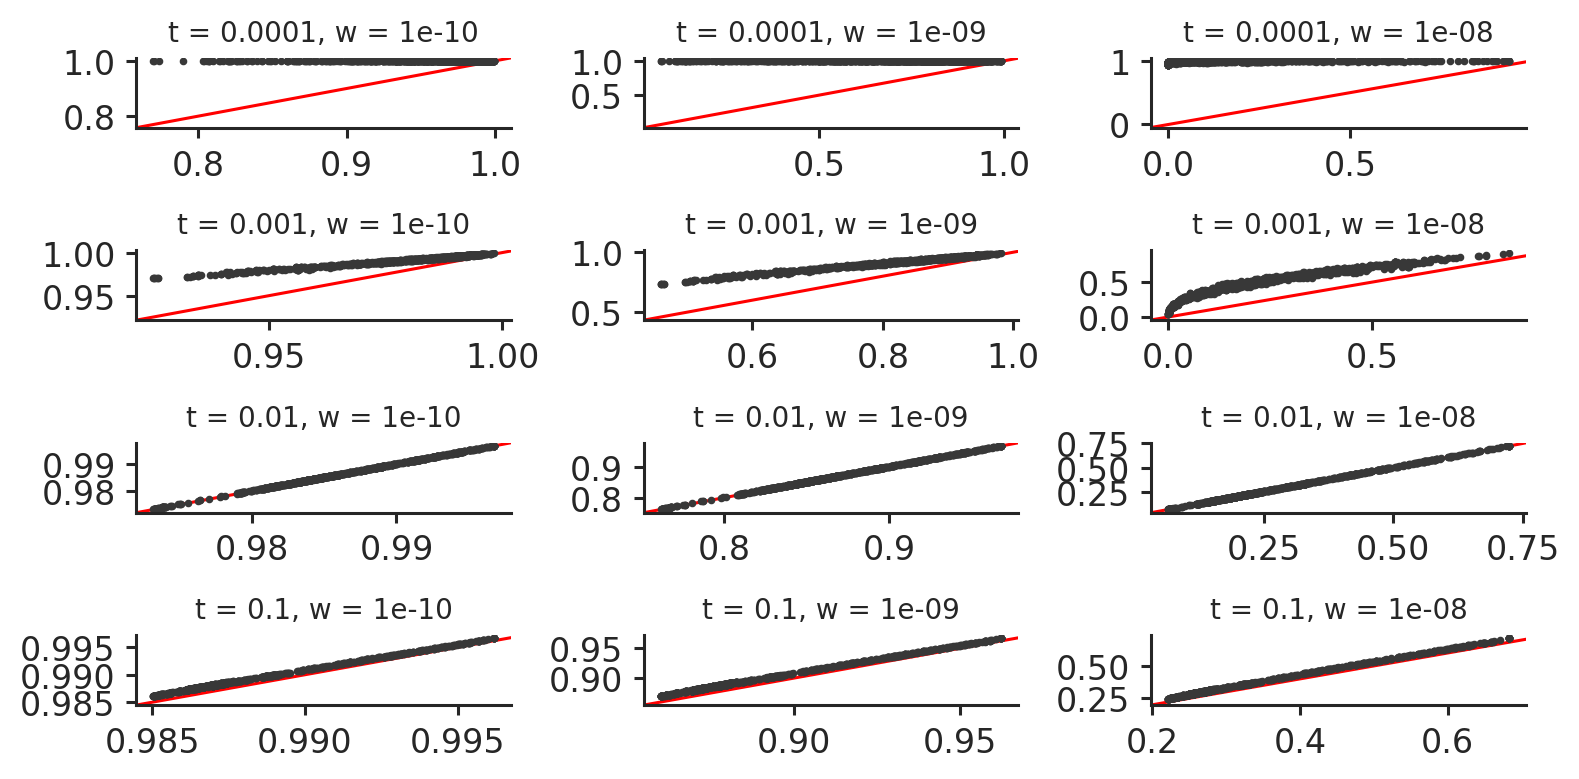

In [341]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sim_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

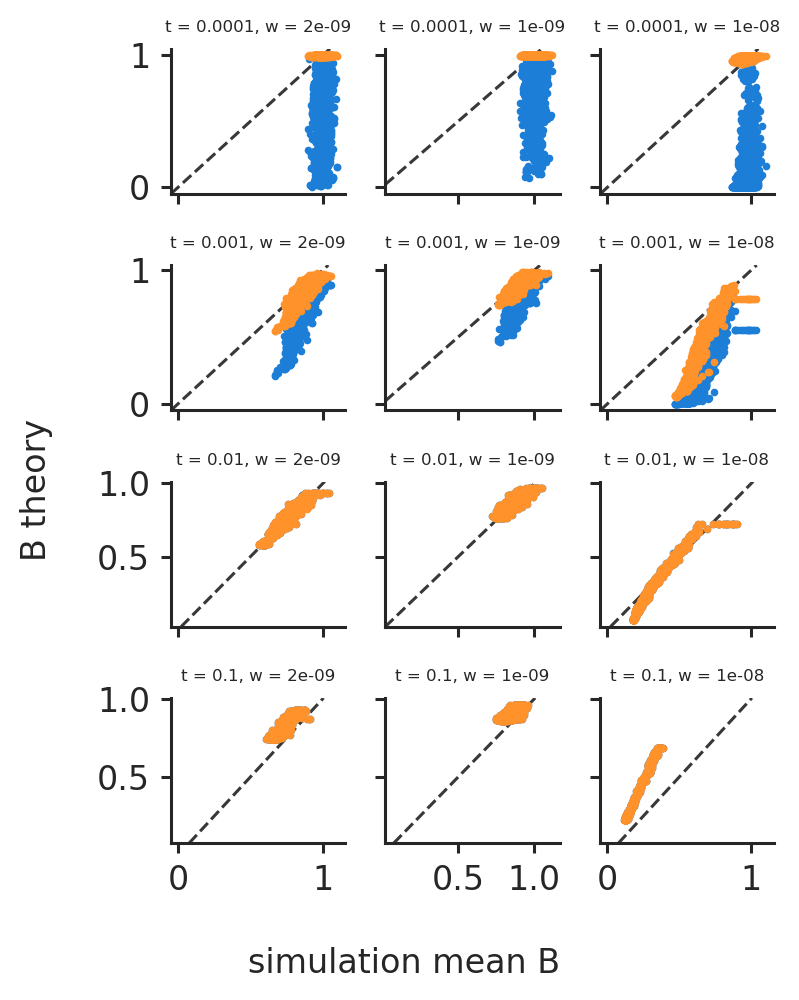

In [135]:
facet_mus = np.array([2.e-9, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, y, s=3)
    ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()